In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

In [2]:
# Load the CSV file
file_path = 'y_obs.csv'
data = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
data.set_index(data.columns[0],inplace=True)

In [3]:
# Function to calculate precipitation indices for a single catchment
def calculate_precipitation_indices(series):
    indices = {}

    # Total precipitation amount
    indices['avgprcp'] = series.sum(skipna=True)/series.count()

    # Daily precipitation amount corresponding to the 90th percentile
    indices['r90p'] = series.quantile(0.9)

    # Daily precipitation amount corresponding to the 95th percentile
    indices['r90p_1'] = series[series >= 1].quantile(0.90)

    # Daily precipitation amount corresponding to the 90th percentile
    indices['r95p'] = series.quantile(0.95)

    # Daily precipitation amount corresponding to the 95th percentile
    indices['r95p_1'] = series[series >= 1].quantile(0.95)

    indices['r25p'] = series.quantile(0.25) # 25th percentile
    # Maximum 1-day precipitation
    indices['rx1day'] = series.max()

    # Maximum 5-day precipitation
    indices['rx5day'] = series.rolling(window=5, min_periods=1).sum().max()

    # Number of days with precipitation ≥ 10 mm
    indices['r10mm'] = (series >= 10).sum()

    # Number of days with precipitation ≥ 20 mm
    indices['r20mm'] = (series >= 20).sum()

    # Number of wet days (precipitation ≥ 1 mm)
    indices['wetdays'] = (series >= 1).sum()

    # Number of very wet days (≥ 95th percentile of non-zero precipitation days)
    very_wet_threshold = series[series >= 1].quantile(0.95)
    indices['verywetdays'] = (series >= very_wet_threshold).sum()

    # Number of extremely wet days (≥ 99th percentile of non-zero precipitation days)
    extremely_wet_threshold = series[series >= 1].quantile(0.99)
    indices['extremewetdays'] = (series >= extremely_wet_threshold).sum()

    # Calculate RUNAB
    median = series.median()
    series_ab = series.apply(lambda x: 'A' if x > median else 'B')
    runs = (series_ab != series_ab.shift(1)).sum()
    
    n1 = (series_ab == 'A').sum()
    n2 = (series_ab == 'B').sum()
    
    if n1 > 20 and n2 > 20:
        mu = (2 * n1 * n2) / (n1 + n2) + 1
        sigma = np.sqrt((2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2)**2 * (n1 + n2 - 1)))
        z = abs(runs - mu) / sigma
        indices['RUNAB'] = z

     # Calculate Spearman lag-1 autocorrelation for ranks
    ranks = series.rank()
    ranks_lag1 = ranks.shift(1)
    valid_idx = ranks_lag1.notna() & ranks.notna()
    spearman_corr, _ = spearmanr(ranks[valid_idx], ranks_lag1[valid_idx])
    indices['spearman_lag1'] = spearman_corr    

    return pd.Series(indices)

In [4]:
import pandas as pd
import numpy as np

def calculate_max_timing(df):
    # Ensure the index is a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The dataframe index must be a DatetimeIndex.")
    
    # Create an empty DataFrame to store the results
    max_timing_df = pd.DataFrame(index=df.resample('Y').mean().index, columns=df.columns)

    # Iterate over each column (catchment)
    for catchment in df.columns:
        # Resample the data to yearly frequency and find the index of the maximum value
        max_dates = df[catchment].resample('Y').apply(lambda x: x.idxmax())
        
        # Check if all max_dates are NaN
        if max_dates.isnull().all():
            max_timing_df[catchment] = np.nan  # Assign NaN if all are NaN
        else:
            # Calculate day of the year (1-365 or 366 for leap years)
            day_of_year = max_dates.dt.month
            
            # Replace NaN with NaN (not necessary, just for clarity)
            day_of_year = day_of_year.fillna(np.nan).astype(float)
            
            # Store the day of year in the result DataFrame
            max_timing_df[catchment] = day_of_year

    return max_timing_df


In [5]:
max_timing = calculate_max_timing(data)

In [6]:
type(max_timing.mode().iloc[0])

pandas.core.series.Series

In [7]:
# Apply the function to each column
results_df = data.apply(calculate_precipitation_indices, axis=0)
results_df = results_df.T
results_df['Catchment'] = results_df.index
results_df['Timing'] = max_timing.mode().iloc[0]
print(results_df)

                 avgprcp    r90p  r90p_1    r95p   r95p_1   r25p  rx1day  \
GRDC_6140100    2.383335   6.770  11.283  10.571  14.7105  0.070   46.24   
GRDC_6140101    2.279040   6.540  10.670   9.980  14.6275  0.060   46.73   
GRDC_6140120    2.285547   6.822  11.150  10.170  14.8910  0.040   60.86   
GRDC_6140130    3.103167   9.022  12.608  12.545  16.6475  0.080   53.13   
GRDC_6140140    2.998241   8.710  12.456  12.312  16.2920  0.060   59.22   
...                  ...     ...     ...     ...      ...    ...     ...   
camelsgb_95001  4.257740  10.612  12.370  13.832  15.7700  0.605   44.85   
camelsgb_96001  3.211281   8.106   9.786  10.521  12.6240  0.440   51.77   
camelsgb_96002  3.436948   8.600  10.280  11.531  13.3880  0.450   50.82   
camelsgb_96004  3.827994   9.530  11.311  12.420  14.4800  0.540   51.14   
camelsgb_97002  2.758255   7.042   8.990   9.591  11.5750  0.340   47.02   

                rx5day  r10mm  r20mm  wetdays  verywetdays  extremewetdays  \
GRDC_6140

In [8]:
results_df['Timing']

GRDC_6140100       7.0
GRDC_6140101       8.0
GRDC_6140120       9.0
GRDC_6140130       8.0
GRDC_6140140       8.0
                  ... 
camelsgb_95001     1.0
camelsgb_96001     5.0
camelsgb_96002     8.0
camelsgb_96004     1.0
camelsgb_97002    10.0
Name: Timing, Length: 1804, dtype: float64

In [9]:
results_df.to_csv('indices_obs.csv')

In [10]:
# Load the CSV file
file_path = 'y_sim.csv'
data_sim = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
data_sim.set_index(data_sim.columns[0],inplace=True)

In [11]:
# Calculate indices for each year and each catchment
# Apply the function to each column
max_timing2 = calculate_max_timing(data_sim)
results_df_sim = data_sim.apply(calculate_precipitation_indices, axis=0)
results_df_sim = results_df_sim.T 
results_df_sim['Catchment'] = results_df_sim.index
results_df_sim['Timing'] = max_timing2.mode().iloc[0]
print(results_df_sim)

C:\Users\as2023\AppData\Local\Temp\ipykernel_7568\4239524376.py:6: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True)/series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_7568\4239524376.py:6: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True)/series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_7568\4239524376.py:6: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True)/series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_7568\4239524376.py:6: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True)/series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_7568\4239524376.py:6: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True)/series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_7568\4239524376

                    RUNAB   avgprcp  extremewetdays  r10mm  r20mm      r25p  \
GRDC_6140100    26.035785  2.367864            33.0  160.0   21.0  0.553091   
GRDC_6140101    25.873653  2.309517            32.0  154.0   14.0  0.530644   
GRDC_6140120    26.062807  2.427099            33.0  155.0   23.0  0.556609   
GRDC_6140130    28.143509  3.343540            39.0  301.0   40.0  0.798757   
GRDC_6140140    27.549023  3.075028            36.0  288.0   36.0  0.645763   
...                   ...       ...             ...    ...    ...       ...   
camelsgb_95001  40.786341  4.235065            30.0  285.0   19.0  1.417267   
camelsgb_96001  40.107920  3.141391            29.0  125.0    6.0  1.153852   
camelsgb_96002  41.834808  3.263904            28.0  150.0   11.0  1.085654   
camelsgb_96004  39.737873  4.031826            29.0  296.0   15.0  1.245167   
camelsgb_97002  38.442707  2.852202            28.0   97.0    7.0  1.111167   

                    r90p     r90p_1       r95p     

In [12]:
results_df_sim.to_csv('indices_sim.csv')

In [13]:
# Load the second CSV file containing basin_id, lat, and lon
df2 = pd.read_csv(r"C:\Users\as2023\bwSyncShare\01_Analysis\03_Backward_Hydrology\01_Analysis\01_baseline\grdc_caravan.csv", usecols=['gauge_id', 'gauge_lat', 'gauge_lon'])
df3 = pd.read_csv(r"S:\ashish\01_Analysis\01_Europe_Flood_Analysis\Caravan\Caravan\attributes\camelsgb\attributes_other_camelsgb.csv",usecols=['gauge_id', 'gauge_lat', 'gauge_lon'])
# Rename 'gauge_id' 
df2.rename(columns={'gauge_id': 'Catchment'}, inplace=True)
df3.rename(columns={'gauge_id': 'Catchment'}, inplace=True)

In [14]:
combined_df = pd.concat([df2, df3], axis=0, ignore_index=True) 
combined_df 

Catchment  gauge_lat  gauge_lon
0       GRDC_1159100 -28.756300  17.718800
1       GRDC_1159103 -28.960400  19.152100
2       GRDC_1159105 -28.077100  16.897900
3       GRDC_1159110 -31.803000  20.356000
4       GRDC_1159120 -31.822000  20.578000
...              ...        ...        ...
5760  camelsgb_95001  58.174122  -5.152603
5761  camelsgb_96001  58.478811  -3.903019
5762  camelsgb_96002  58.480072  -4.207749
5763  camelsgb_96004  58.347177  -4.644621
5764  camelsgb_97002  58.515497  -3.493004

[5765 rows x 3 columns]

In [15]:
# Read the CSV files containing average indices for simulated and observed data
simulated_indices = pd.read_csv('indices_sim.csv', index_col=0)
observed_indices = pd.read_csv('indices_obs.csv', index_col=0)

# Add suffixes to columns to distinguish between simulated and observed data
simulated_indices.columns = [col + '_sim' for col in simulated_indices.columns]
observed_indices.columns = [col + '_obs' for col in observed_indices.columns]

# Merge the two DataFrames on the index
merged_indices = pd.merge(simulated_indices, observed_indices, left_index=True, right_index=True)

# Save the merged DataFrame to a new CSV file
merged_indices.to_csv('merged_indices.csv')

print("Merged indices saved successfully.")

Merged indices saved successfully.


In [16]:
merged_indices

RUNAB_sim  avgprcp_sim  extremewetdays_sim  r10mm_sim  \
GRDC_6140100    26.035785     2.367864                33.0      160.0   
GRDC_6140101    25.873653     2.309517                32.0      154.0   
GRDC_6140120    26.062807     2.427099                33.0      155.0   
GRDC_6140130    28.143509     3.343540                39.0      301.0   
GRDC_6140140    27.549023     3.075028                36.0      288.0   
...                   ...          ...                 ...        ...   
camelsgb_95001  40.786341     4.235065                30.0      285.0   
camelsgb_96001  40.107920     3.141391                29.0      125.0   
camelsgb_96002  41.834808     3.263904                28.0      150.0   
camelsgb_96004  39.737873     4.031826                29.0      296.0   
camelsgb_97002  38.442707     2.852202                28.0       97.0   

                r20mm_sim  r25p_sim  r90p_sim  r90p_1_sim   r95p_sim  \
GRDC_6140100         21.0  0.553091  5.508725    7.192452   7.883290   
GRDC_6140101         14.0  0.530644  5.411275    7.233247   7.810928   
GRDC_6140120         23.0  0.556609  5.799867    7.369849   7.946948   
GRDC_6140130         40.0  0.798757  7.844628    9.187999  10.345448   
GRDC_6140140         36.0  0.645763  7.335315    9.026909  10.195844   
...                   ...       ...       ...         ...        ...   
camelsgb_95001       19.0  1.417267  9.312171    9.899368  11.902305   
camelsgb_96001        6.0  1.153852  6.805154    7.608016   9.037654   
camelsgb_96002       11.0  1.085654  7.228884    8.023920   9.401569   
camelsgb_96004       15.0  1.245167  9.336341   10.093671  11.687270   
camelsgb_97002        7.0  1.111167  5.914597    6.576867   8.043733   

                r95p_1_sim  ...  rx5day_obs  r10mm_obs  r20mm_obs  \
GRDC_6140100      9.875981  ...      101.48      299.0       44.0   
GRDC_6140101      9.879318  ...       97.38      272.0       39.0   
GRDC_6140120      9.746201  ...      104.07      289.0       44.0   
GRDC_6140130     11.725078  ...      112.26      464.0       77.0   
GRDC_6140140     11.698838  ...      107.06      434.0       77.0   
...                    ...  ...         ...        ...        ...   
camelsgb_95001   12.578969  ...       92.40      635.0       90.0   
camelsgb_96001    9.644995  ...       99.46      327.0       28.0   
camelsgb_96002   10.214422  ...       96.91      392.0       35.0   
camelsgb_96004   12.572185  ...       97.49      486.0       51.0   
camelsgb_97002    9.034846  ...       89.58      246.0       20.0   

                wetdays_obs  verywetdays_obs extremewetdays_obs  RUNAB_obs  \
GRDC_6140100         2420.0            121.0               25.0  21.630681   
GRDC_6140101         2356.0            118.0               24.0  22.063330   
GRDC_6140120         2267.0            114.0               23.0  23.738532   
GRDC_6140130         2722.0            137.0               28.0  23.900960   
GRDC_6140140         2657.0            133.0               27.0  24.170783   
...                     ...              ...                ...        ...   
camelsgb_95001       3786.0            190.0               38.0  25.279089   
camelsgb_96001       3483.0            175.0               35.0  20.117860   
camelsgb_96002       3585.0            180.0               36.0  21.847319   
camelsgb_96004       3670.0            185.0               37.0  23.630819   
camelsgb_97002       3271.0            164.0               33.0  17.199015   

                spearman_lag1_obs   Catchment_obs  Timing_obs  
GRDC_6140100             0.413244    GRDC_6140100         7.0  
GRDC_6140101             0.413398    GRDC_6140101         8.0  
GRDC_6140120             0.431562    GRDC_6140120         9.0  
GRDC_6140130             0.448330    GRDC_6140130         8.0  
GRDC_6140140             0.456266    GRDC_6140140         8.0  
...                           ...             ...         ...  
camelsgb_95001           0.488937  camelsgb_95001         1.

In [17]:
merged_indices = merged_indices.rename(columns={'Catchment_sim': 'Catchment'})

In [18]:
# Merge the two dataframes based on the 'basin_id' column
merged_df = pd.merge(merged_indices, combined_df , on='Catchment', how='inner')

In [19]:
merged_df

RUNAB_sim  avgprcp_sim  extremewetdays_sim  r10mm_sim  r20mm_sim  \
0     26.035785     2.367864                33.0      160.0       21.0   
1     25.873653     2.309517                32.0      154.0       14.0   
2     26.062807     2.427099                33.0      155.0       23.0   
3     28.143509     3.343540                39.0      301.0       40.0   
4     27.549023     3.075028                36.0      288.0       36.0   
...         ...          ...                 ...        ...        ...   
1799  40.786341     4.235065                30.0      285.0       19.0   
1800  40.107920     3.141391                29.0      125.0        6.0   
1801  41.834808     3.263904                28.0      150.0       11.0   
1802  39.737873     4.031826                29.0      296.0       15.0   
1803  38.442707     2.852202                28.0       97.0        7.0   

      r25p_sim  r90p_sim  r90p_1_sim   r95p_sim  r95p_1_sim  ...  r20mm_obs  \
0     0.553091  5.508725    7.192452   7.883290    9.875981  ...       44.0   
1     0.530644  5.411275    7.233247   7.810928    9.879318  ...       39.0   
2     0.556609  5.799867    7.369849   7.946948    9.746201  ...       44.0   
3     0.798757  7.844628    9.187999  10.345448   11.725078  ...       77.0   
4     0.645763  7.335315    9.026909  10.195844   11.698838  ...       77.0   
...        ...       ...         ...        ...         ...  ...        ...   
1799  1.417267  9.312171    9.899368  11.902305   12.578969  ...       90.0   
1800  1.153852  6.805154    7.608016   9.037654    9.644995  ...       28.0   
1801  1.085654  7.228884    8.023920   9.401569   10.214422  ...       35.0   
1802  1.245167  9.336341   10.093671  11.687270   12.572185  ...       51.0   
1803  1.111167  5.914597    6.576867   8.043733    9.034846  ...       20.0   

      wetdays_obs  verywetdays_obs  extremewetdays_obs  RUNAB_obs  \
0          2420.0            121.0                25.0  21.630681   
1          2356.0            118.0                24.0  22.063330   
2          2267.0            114.0                23.0  23.738532   
3          2722.0            137.0                28.0  23.900960   
4          2657.0            133.0                27.0  24.170783   
...           ...              ...                 ...        ...   
1799       3786.0            190.0                38.0  25.279089   
1800       3483.0            175.0                35.0  20.117860   
1801       3585.0            180.0                36.0  21.847319   
1802       3670.0            185.0                37.0  23.630819   
1803       3271.0            164.0                33.0  17.199015   

     spearman_lag1_obs   Catchment_obs  Timing_obs  gauge_lat  gauge_lon  
0             0.413244    GRDC_6140100         7.0  50.531200  16.189600  
1             0.413398    GRDC_6140101         8.0  50.481300  16.181200  
2             0.431562    GRDC_6140120         9.0  49.889600  15.481200  
3             0.448330    GRDC_6140130         8.0  50.639600  15.518800  
4             0.456266    GRDC_6140140         8.0  50.656200  15.327100  
...                ...             ...         ...        ...        ...  
1799          0.488937  camelsgb_95001         1.0  58.174122  -5.152603  
1800          0.400437  camelsgb_96001         5.0  58.478811  -3.903019  
1801          0.435498  camelsgb_96002         8.0  58.480072  -4.207749  
1802          0.467300  camelsgb_96004         1.0  58.347177  -4.644621  
1803          0.364872  camelsgb_97002        10.0  58.515497  -3.493004  

[1804 rows x 36 columns]

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_world_map(df, index_column, extent, vmin=None, vmax=None):
    df_cleaned = df.dropna(subset=['gauge_lat', 'gauge_lon', index_column])
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent(extent)

    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.OCEAN, color='white')
    ax.add_feature(cfeature.COASTLINE)
    
    # Get the minimum and maximum values of the index column for custom colormap limits
    if vmin is None:
        vmin = df_cleaned[index_column].min()
    if vmax is None:
        vmax = df_cleaned[index_column].max()

    # Plot the latitude and longitude points with the specified index values
    sc = ax.scatter(df_cleaned['gauge_lon'], df_cleaned['gauge_lat'], c=df_cleaned[index_column], cmap='viridis', 
                    marker='o', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, s=10, edgecolors='white', linewidths=0.2)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax,  shrink=0.6, extend='both')
    cbar.set_label(index_column)

    ax.coastlines()

    plt.show()


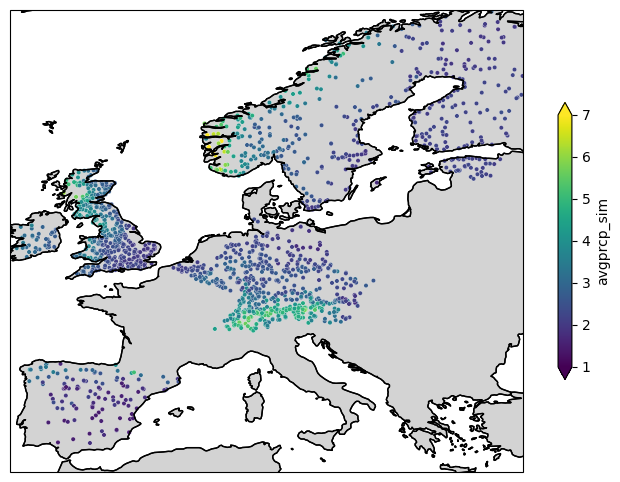

In [21]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'avgprcp_sim'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =1, vmax=7)

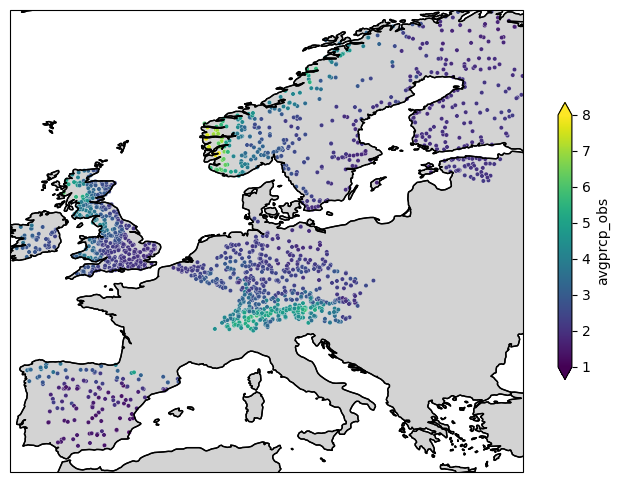

In [22]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'avgprcp_obs'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =1, vmax=8)

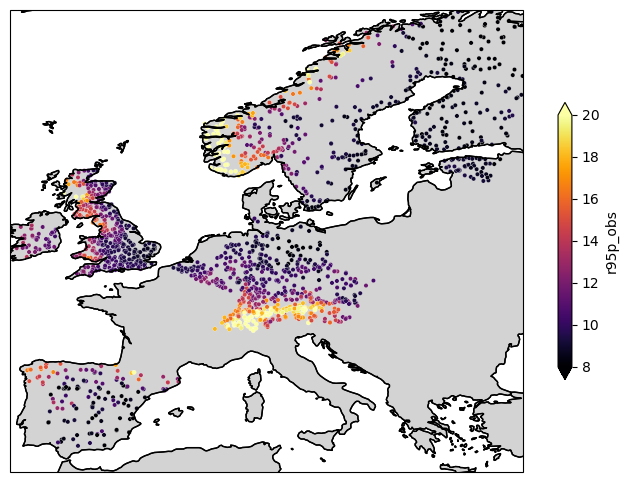

In [118]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'r95p_obs'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =8, vmax=20)

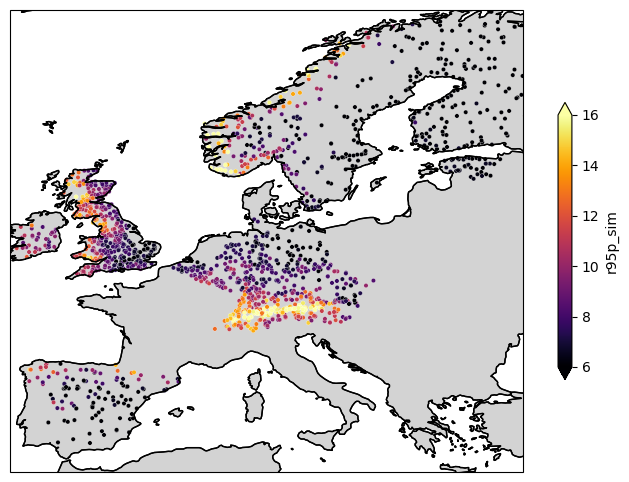

In [120]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'r95p_sim'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =6, vmax=16)

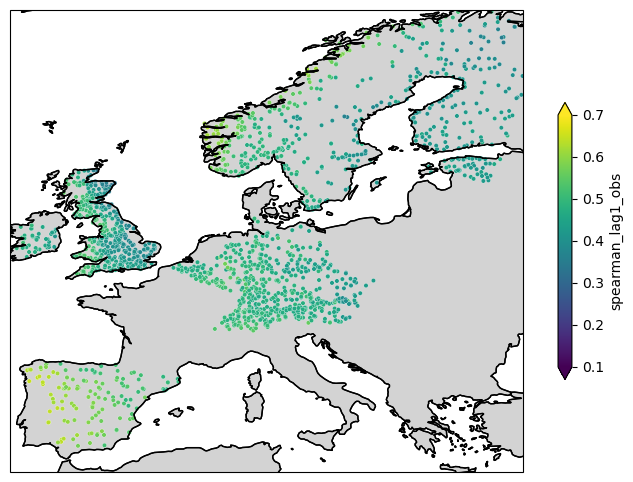

In [25]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'spearman_lag1_obs'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =0.1, vmax=0.7)

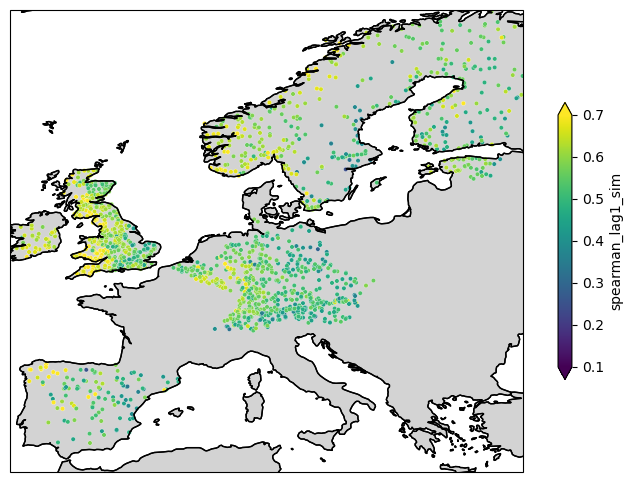

In [26]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'spearman_lag1_sim'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =0.1, vmax=0.7)

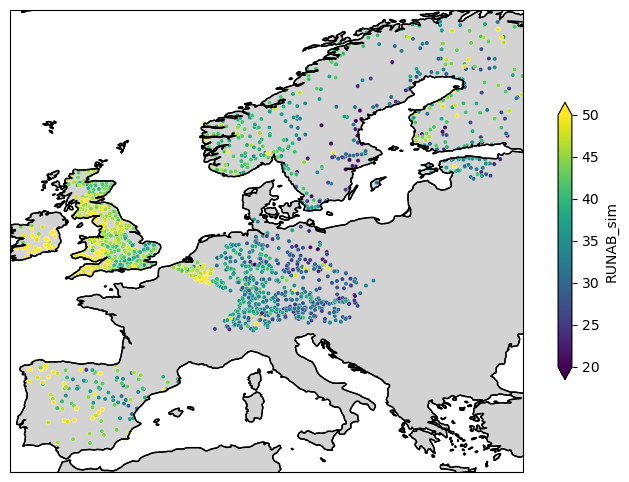

In [138]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'RUNAB_sim'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =20, vmax=50)

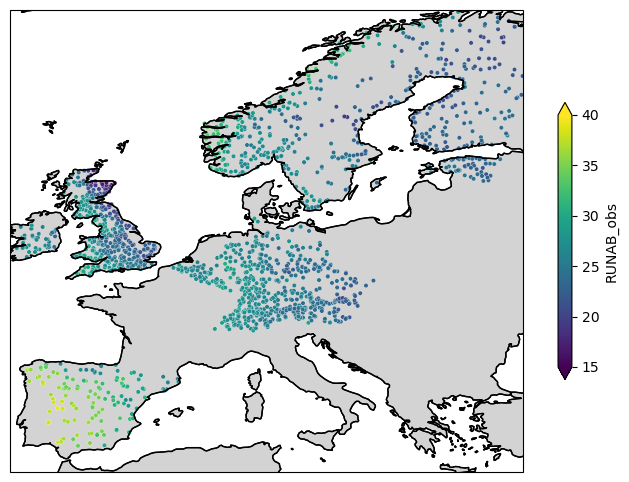

In [139]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'RUNAB_obs'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =15, vmax=40)

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

def plot_world_map(df, index_column, extent):
    # Clean the DataFrame by dropping rows with NaN in critical columns
    df_cleaned = df.dropna(subset=['gauge_lat', 'gauge_lon', index_column])

    # Define a discrete colormap with 12 distinct colors for the 12 months
    cmap = mcolors.ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                                   '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
                                   '#aec7e8', '#ffbb78'])
    norm = mcolors.BoundaryNorm(boundaries=np.arange(1, 14), ncolors=12)

    # Create a figure and an axis with a specific projection
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Set the extent of the map
    ax.set_extent(extent)

    # Add geographical features to the map
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.OCEAN, color='white')
    ax.add_feature(cfeature.COASTLINE)

    # Plot the data points with latitude and longitude, colored by the specified index column
    sc = ax.scatter(
        df_cleaned['gauge_lon'], df_cleaned['gauge_lat'], 
        c=df_cleaned[index_column], cmap=cmap, norm=norm,
        marker='o', transform=ccrs.PlateCarree(), 
        s=10, edgecolors='white', linewidths=0.2
    )

    # Create legend for colormap
    legend_handles = []
    for month in range(1, 13):
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markersize=10,
                                         markerfacecolor=cmap((month - 1) / 11)))
    ax.legend(legend_handles, 
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
              title='Months', loc='lower right', fontsize='small')

    # Add coastlines for better visualization
    ax.coastlines()

    # Display the plot
    plt.show()




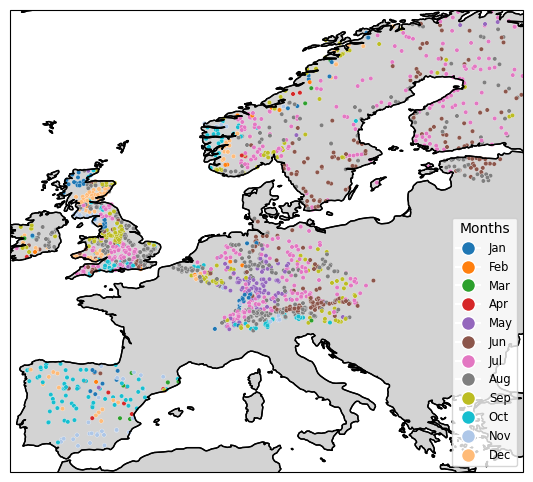

In [37]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'Timing_obs'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent)

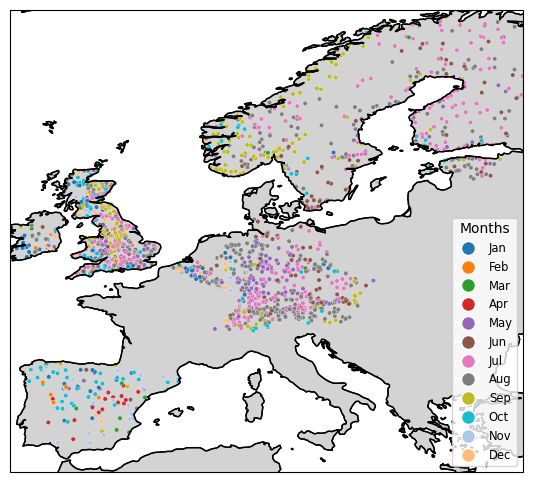

In [38]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'Timing_sim'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent)

In [146]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def day_to_month(day_of_year):
    """
    Convert day of year (1-365) to month (1-12).
    """
    days_in_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    cum_days = np.cumsum(days_in_months)
    month = np.digitize(day_of_year, cum_days, right=True) + 1
    return month

def plot_world_map(df, index_column, extent):
    df_cleaned = df.dropna(subset=['gauge_lat', 'gauge_lon', index_column])
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent(extent)

    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.OCEAN, color='white')
    ax.add_feature(cfeature.COASTLINE)
    
    # Convert day of year to month
    df_cleaned['month'] = df_cleaned[index_column].apply(day_to_month)
    
    # Determine unique months
    unique_months = np.sort(df_cleaned['month'].unique())
    num_unique_months = len(unique_months)
    
    # Create a categorical colormap based on 12 distinct colors for 12 months
    cmap = plt.cm.get_cmap('tab20', 12)  # Using 'tab20' colormap for 12 colors
    
    # Plot the latitude and longitude points with the specified month values
    sc = ax.scatter(df_cleaned['gauge_lon'], df_cleaned['gauge_lat'], c=df_cleaned['month'], cmap=cmap, 
                    marker='o', transform=ccrs.PlateCarree(), s=10, edgecolors='white', linewidths=0.2)

    # Add colorbar with discrete ticks for each month (1-12)
    cbar = plt.colorbar(sc, ax=ax, ticks=np.arange(1, 13), shrink=0.6, extend='both')
    cbar.set_label('Month')
    
    # Create legend for colormap
    legend_handles = []
    for month in range(1, 13):
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markersize=10,
                                         markerfacecolor=cmap((month - 1) / 11)))
    ax.legend(legend_handles, np.arange(1, 13), title='Months', loc='lower right', fontsize='small')

    ax.coastlines()

    plt.show()

# Example usage:
# Assuming df is your DataFrame with 'gauge_lat', 'gauge_lon', and index_column representing days of the year (1 to 365)
# extent = [longitude_min, longitude_max, latitude_min, latitude_max]
# plot_world_map(df, index_column='day_of_year', extent=extent)




C:\Users\as2023\AppData\Local\Temp\ipykernel_1104\4237843201.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', 12)  # Using 'tab20' colormap for 12 colors


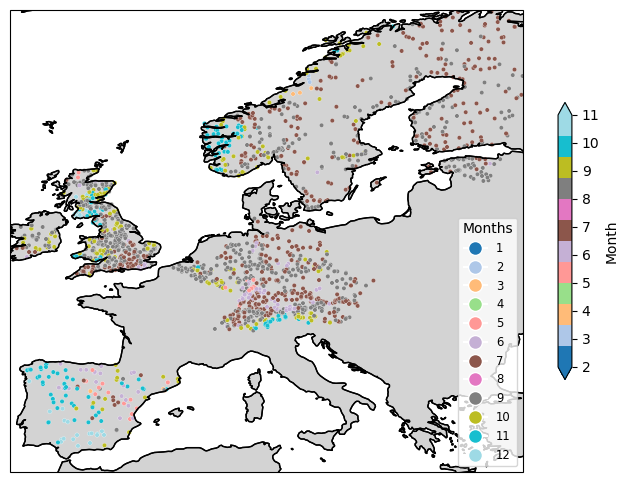

In [147]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'Timing_obs'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent)

C:\Users\as2023\AppData\Local\Temp\ipykernel_1104\4237843201.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['month'] = df_cleaned[index_column].apply(day_to_month)
C:\Users\as2023\AppData\Local\Temp\ipykernel_1104\4237843201.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', 12)  # Using 'tab20' colormap for 12 colors


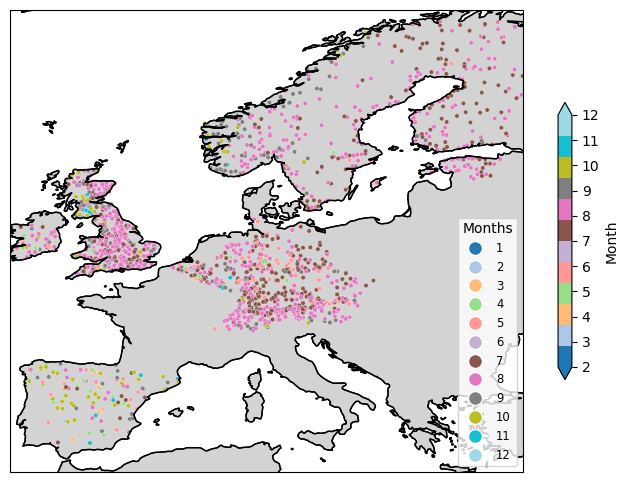

In [148]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'Timing_sim'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent)

In [121]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_comparison_maps(simulated_df, observed_df, index_column, extent, vmin=None, vmax=None):
    # Clean the simulated and observed DataFrames by dropping NaN values in relevant columns
    simulated_df_cleaned = simulated_df.dropna(subset=['gauge_lat', 'gauge_lon', index_column + '_sim'])
    observed_df_cleaned = observed_df.dropna(subset=['gauge_lat', 'gauge_lon', index_column + '_obs'])
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    for ax, df, suffix in zip(axes, [simulated_df_cleaned, observed_df_cleaned], ['_sim', '_obs']):
        ax.set_extent(extent)

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.COASTLINE)

        index_col = index_column + suffix

        # Use the provided vmin and vmax if given, otherwise use the data range
        color_min = vmin if vmin is not None else df[index_col].min()
        color_max = vmax if vmax is not None else df[index_col].max()

        sc = ax.scatter(df['gauge_lon'], df['gauge_lat'], c=df[index_col], cmap='viridis', 
                        marker='o', transform=ccrs.PlateCarree(), vmin=color_min, vmax=color_max, s=10, edgecolors='white', linewidths=0.2)

        cbar = plt.colorbar(sc, ax=ax, shrink=0.6, extend='both')
        cbar.set_label(index_column + suffix)

        ax.coastlines()

    plt.show()


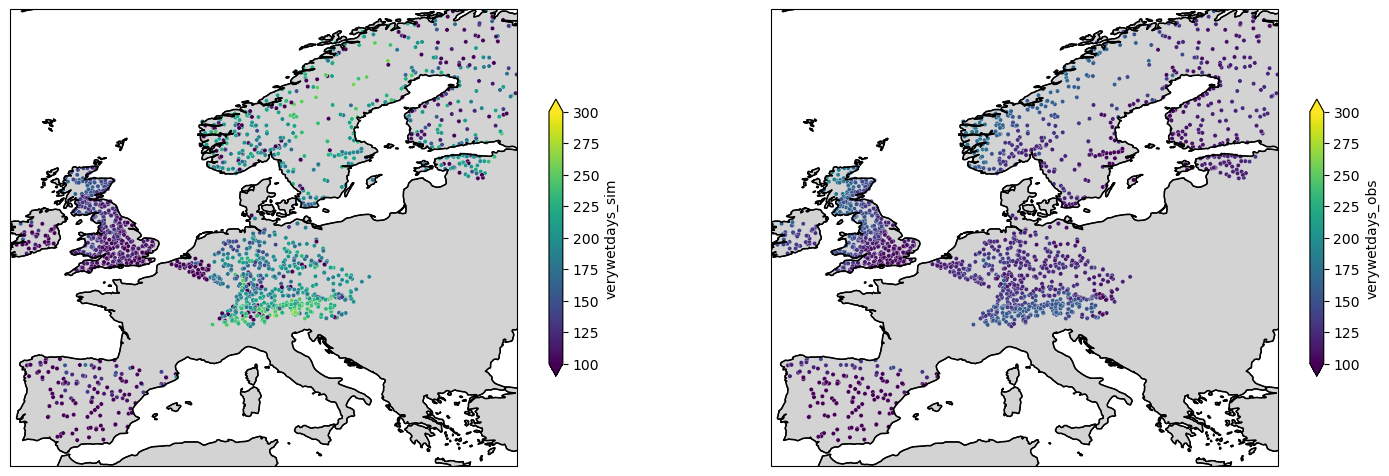

In [123]:
# Manually set the latitude and longitude extent for Europe
europe_extent = [-10, 30, 35, 70]

# Specify the index column to plot
index_column = 'verywetdays'  # Replace 'NSE' with the name of your index column

# Plot the comparison maps for simulated and observed indices
plot_comparison_maps(simulated_df=merged_df, observed_df=merged_df, index_column=index_column, extent=europe_extent,vmin = 100, vmax=300)

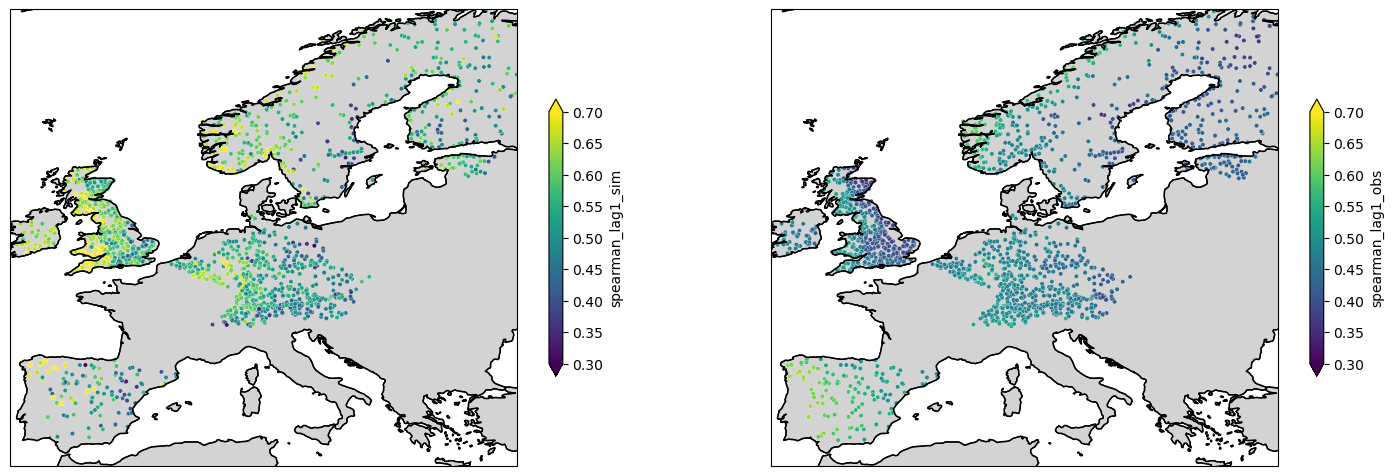

In [88]:
# Manually set the latitude and longitude extent for Europe
europe_extent = [-10, 30, 35, 70]

# Specify the index column to plot
index_column = 'spearman_lag1'  # Replace 'NSE' with the name of your index column

# Plot the comparison maps for simulated and observed indices
plot_comparison_maps(simulated_df=merged_df, observed_df=merged_df, index_column=index_column, extent=europe_extent,vmin = 0.3, vmax=0.7)

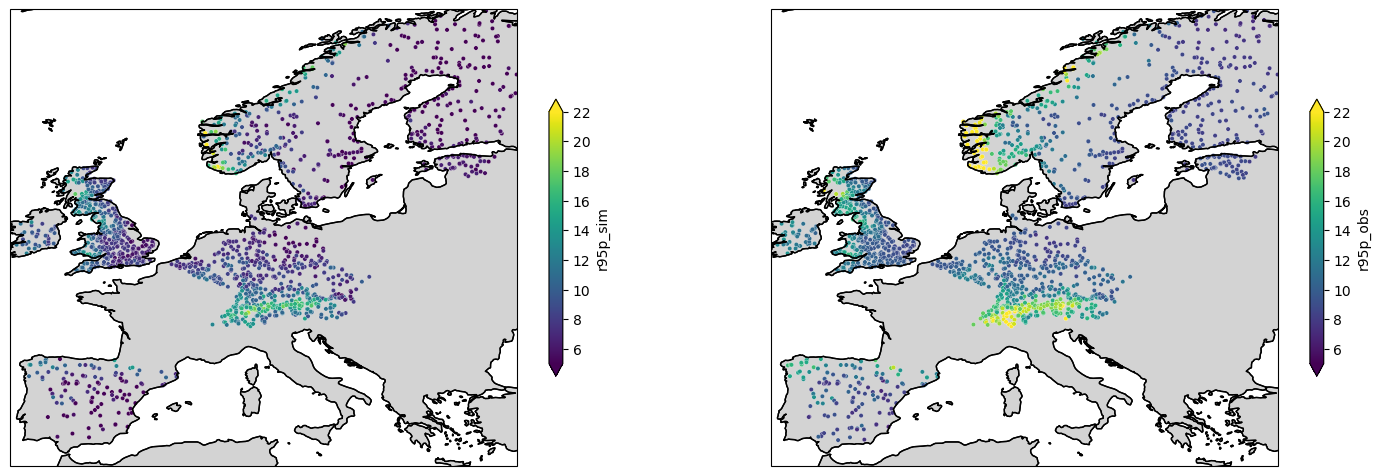

In [21]:
# Manually set the latitude and longitude extent for Europe
europe_extent = [-10, 30, 35, 70]

# Specify the index column to plot
index_column = 'r95p'  # Replace 'NSE' with the name of your index column

# Plot the comparison maps for simulated and observed indices
plot_comparison_maps(simulated_df=merged_df, observed_df=merged_df, index_column=index_column, extent=europe_extent,vmin = 5, vmax=22)

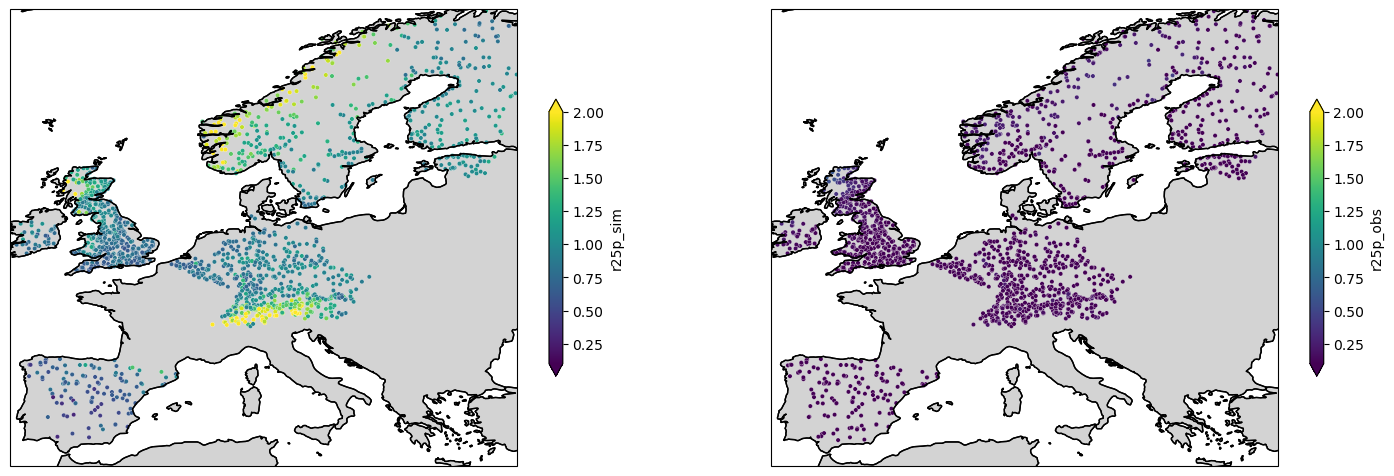

In [27]:
# Manually set the latitude and longitude extent for Europe
europe_extent = [-10, 30, 35, 70]

# Specify the index column to plot
index_column = 'r25p'  # Replace 'NSE' with the name of your index column

# Plot the comparison maps for simulated and observed indices
plot_comparison_maps(simulated_df=merged_df, observed_df=merged_df, index_column=index_column, extent=europe_extent,vmin = 0.1, vmax=2)

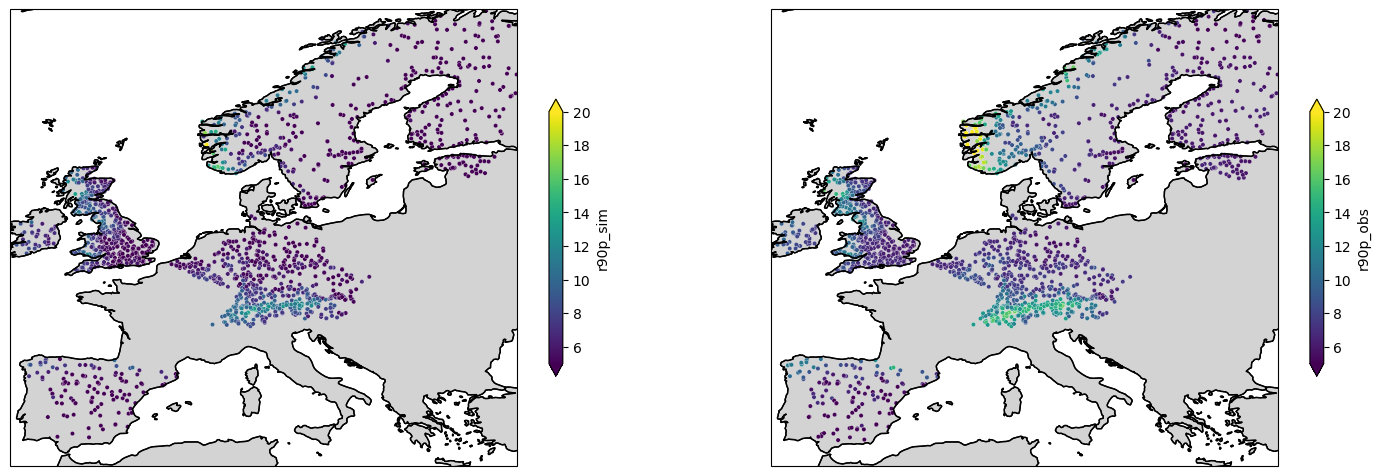

In [67]:
# Specify the index column to plot
index_column = 'r90p'  # Replace 'NSE' with the name of your index column

# Plot the comparison maps for simulated and observed indices
plot_comparison_maps(simulated_df=merged_df, observed_df=merged_df, index_column=index_column, extent=europe_extent,vmin = 5, vmax=20)

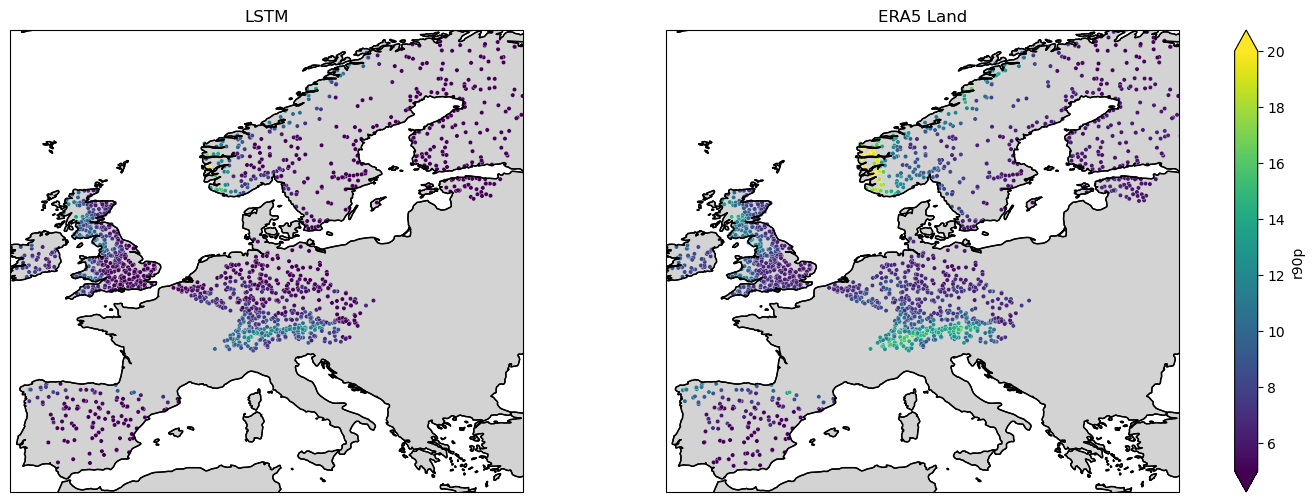

In [79]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_comparison_maps_legend(simulated_df, observed_df, index_column, extent, vmin=None, vmax=None):
    # Clean the simulated and observed DataFrames by dropping NaN values in relevant columns
    simulated_df_cleaned = simulated_df.dropna(subset=['gauge_lat', 'gauge_lon', index_column + '_sim'])
    observed_df_cleaned = observed_df.dropna(subset=['gauge_lat', 'gauge_lon', index_column + '_obs'])

    # Determine the color limits if not provided
    combined_min = min(simulated_df_cleaned[index_column + '_sim'].min(), observed_df_cleaned[index_column + '_obs'].min())
    combined_max = max(simulated_df_cleaned[index_column + '_sim'].max(), observed_df_cleaned[index_column + '_obs'].max())
    color_min = vmin if vmin is not None else combined_min
    color_max = vmax if vmax is not None else combined_max

    fig, axes = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    plt.subplots_adjust(wspace=0.0000001)
    
    titles = ['LSTM', 'ERA5 Land']
    
    for ax, df, suffix, title in zip(axes, [simulated_df_cleaned, observed_df_cleaned], ['_sim', '_obs'], titles):
        ax.set_extent(extent)

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.COASTLINE)

        index_col = index_column + suffix

        sc = ax.scatter(df['gauge_lon'], df['gauge_lat'], c=df[index_col], cmap='viridis', 
                        marker='o', transform=ccrs.PlateCarree(), vmin=color_min, vmax=color_max, s=10, edgecolors='white', linewidths=0.2)

        ax.coastlines()
        
        # Add title to subplot
        ax.set_title(title)

    # Add a single colorbar for both subplots
    cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, extend='both')
    cbar.set_label(index_column)

    plt.show()

# Example function call
plot_comparison_maps_legend(merged_df, merged_df, 'r90p', europe_extent, vmin=5, vmax=20)



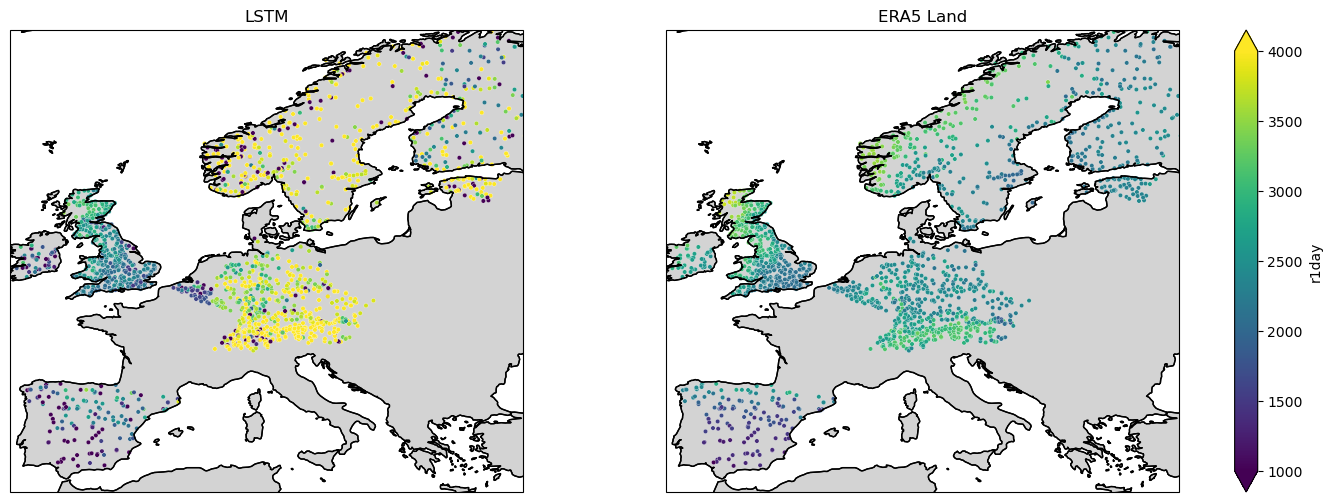

In [81]:
plot_comparison_maps_legend(merged_df, merged_df, 'r1day', europe_extent, vmin=1000, vmax=4000)